# Run Mantel tests

Specify input distances and output file:

In [1]:
# input files
phylodist_file <- "results/clade_founder_tree/clade_founders.mldist"
ratesdist_file <- "results/synonymous_mut_rates/clade_rate_distances.csv"

outdir <- "results/mantel_test"
dir.create(outdir,showWarnings = F)

Load packages and set seed:

In [2]:
require(vegan) # for mantel test 
require(dplyr)
require(tidyverse)
require(ggplot2)
require(cowplot)
require(scales)
require(broom) # for tidying distance matrix

Loading required package: vegan

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyverse

── Attaching packages ───────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.5
✔ tibble  3.1.8     ✔ stringr 1.4.1
✔ tidyr   1.2.1     ✔ forcats 0.5.2
✔ readr   2.1.3     
── Conflicts ──────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: cowplot

Loading required package: scales


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘pack

Read data and setup for tests:

In [3]:
# read phylogenetic distances, skipping row 1 (empty) and setting row names equal to column 1 
phylodist <- read.table(phylodist_file, header=F, skip=1, row.names=1)
# make column names the same as row names:
colnames(phylodist) <- rownames(phylodist)

phylodist %>% head

,19A,20A,20B,20C,20E,20F,20G,20I,20J,21C,21F,21I,21J,21K,21L,22A,22B,22C
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19A,0.0000000,0.0031065,0.0054559,0.0046648,0.0085957,0.0101791,0.0101387,0.0221966,0.0262622,0.0101614,0.0109265,0.0220992,0.0253352,0.0435225,0.0536197,0.0561941,0.0518514,0.0570250
20A,0.0031065,0.0000000,0.0023342,0.0015523,0.0054608,0.0070352,0.0070075,0.0189936,0.0230385,0.0070231,0.0077912,0.0189099,0.0221297,0.0402297,0.0502850,0.0528464,0.0485283,0.0536752
20B,0.0054559,0.0023342,0.0000000,0.0038947,0.0078291,0.0046733,0.0093767,0.0165591,0.0205806,0.0093978,0.0101646,0.0205634,0.0238015,0.0376766,0.0476749,0.0502205,0.0459317,0.0510459
20C,0.0046648,0.0015523,0.0038947,0.0000000,0.0070286,0.0086080,0.0054444,0.0205991,0.0246557,0.0054565,0.0062263,0.0205081,0.0237375,0.0418860,0.0519654,0.0545335,0.0502023,0.0553634
20E,0.0085957,0.0054608,0.0078291,0.0070286,0.0000000,0.0125854,0.0125354,0.0246872,0.0287801,0.0125636,0.0133276,0.0229775,0.0278359,0.0461509,0.0563155,0.0589079,0.0545312,0.0597430
20F,0.0101791,0.0070352,0.0046733,0.0086080,0.0125854,0.0000000,0.0141313,0.0213901,0.0254497,0.0141632,0.0149263,0.0254281,0.0286963,0.0410134,0.0510695,0.0536314,0.0493117,0.0544598


In [4]:
# read rates distances
ratesdist <- read.table(ratesdist_file, sep=",", header=T)

ratesdist %>% head

,rate_type,clade_1,clade_2,mut_rate_distance,is_Omicron
,<chr>,<chr>,<chr>,<dbl>,<chr>
1,rates,20A,20B,0.12277,not Omicron
2,no_GtoT_rates,20A,20B,0.13560,not Omicron
3,clr_rates,20A,20B,0.45761,not Omicron
4,rates,20A,20C,0.10540,not Omicron
5,no_GtoT_rates,20A,20C,0.07193,not Omicron
6,clr_rates,20A,20C,0.98075,not Omicron


Do analysis for each rate type:

'nperm' >= set of all permutations: complete enumeration.

Set of permutations < 'minperm'. Generating entire set.



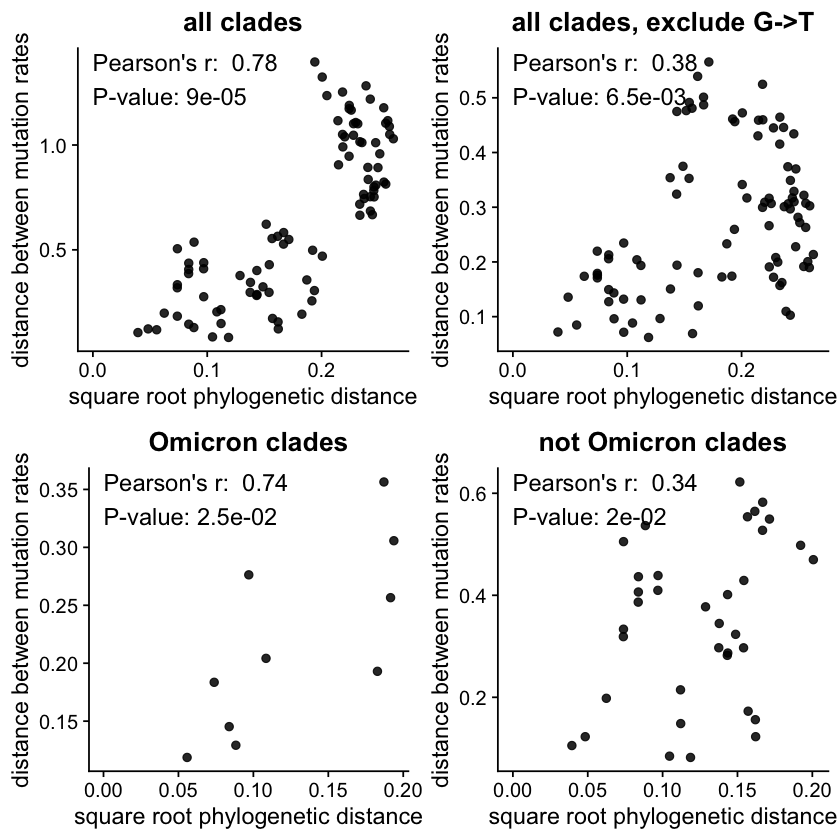

In [5]:
rate_types = ratesdist$rate_type %>% unique

plot_list <- list()

for (is_omicron in c("any", "Omicron", "not Omicron")) {
for (ratetype in rate_types) {
    
    if ((is_omicron != "any") & (ratetype != "rates")) {
        next
    }
    
    if (ratetype == "clr_rates")
        next

    # select just rates of interest and add diagonal
    ratesdist_type <- ratesdist %>% 
        filter(rate_type==ratetype) %>%
        select(!rate_type)
    
    if (is_omicron != "any") {
        ratesdist_type <- ratesdist_type %>% filter(is_Omicron==is_omicron | clade_1 == clade_2)
    }

    clades <- c(ratesdist_type$clade_1, ratesdist_type$clade_2) %>% unique
    
    # self-self comparisons for diagonal
    self_distances_diagonal <- data.frame(
        clade_1=clades,
        clade_2=clades,
        mut_rate_distance=0,
        is_Omicron=is_omicron
    )
    
    ratesdist_type <- bind_rows(ratesdist_type, self_distances_diagonal)
    
    # pivot wider
    ratesdist_matrix <- ratesdist_type %>%
        select(!is_Omicron) %>%
        pivot_wider(names_from=clade_2, values_from=mut_rate_distance) %>%
        column_to_rownames('clade_1') %>%
        as.matrix()

    # reorder columns to match order of rownames
    ratesdist_matrix <- ratesdist_matrix[,rownames(ratesdist_matrix)]

    # this works to fill in the matrix (note both are lower.tri )
    ratesdist_matrix[lower.tri(ratesdist_matrix)] <- t(ratesdist_matrix)[lower.tri(ratesdist_matrix)]
    
    # order the two matrices in the same way
    # also removes clades from the phylo matrix that aren't in spectrum distance matrix
    # finally, take square root of phylogenetic distances
    phylodist_reordered_subset <- sqrt(phylodist[rownames(ratesdist_matrix), colnames(ratesdist_matrix)])
    
    # make sure row/col names are the same 
    if(sum(rownames(phylodist_reordered_subset) != rownames(ratesdist_matrix)) != 0){
        stop("something is wrong with your matrix setup")
    }

    if(sum(colnames(phylodist_reordered_subset) != colnames(ratesdist_matrix)) != 0){
        stop("something is wrong with your matrix setup")
    }
    
    # run the mantel test on square root of phylogenetic distances
    set.seed(1)
    mantelTestResults <- vegan::mantel(
        phylodist_reordered_subset,
        ratesdist_matrix,
        permutations=100000
    ) # default method = pearson
    
    # data frame of results
    mantelTestResult_df <- data.frame(
        method=as.character(mantelTestResults$method),
        statistic=as.numeric(mantelTestResults$statistic),
        permCount=as.numeric(mantelTestResults$permutations),
        signif=as.numeric(mantelTestResults$signif)
    )
    
    # merge distances for plotting
    phylodist_reordered_subset_table <- tidy(as.dist(phylodist_reordered_subset)) # turn into a table

    # this got rid of self-self distances and duplicates
    colnames(phylodist_reordered_subset_table) <- c("clade_1","clade_2","phylogenetic_distance")

    # combine:
    merged_distances <- merge(
        ratesdist_type,
        phylodist_reordered_subset_table,
        by=c("clade_1","clade_2")
    )
    
    # add labels:
    merged_distances$comparison_label <- paste0(merged_distances$clade_1,"x",merged_distances$clade_2)
    
    if (is_omicron == "any")
        title <- "all clades"
    else
        title <- paste0(is_omicron, " clades")
    
    if (ratetype == "no_GtoT_rates")
        title <- paste0(title, ", exclude G->T")
    else if (ratetype == "no_CtoT_rates")
        title <- paste0(title, ", exclude C->T")
    else if (ratetype == "no_CtoT_orGtoT_rates")
        title <- paste0(title, ", exclude C->T and G->T")
    else if (ratetype != "rates")
        title <- paste0(title, " ", ratetype)

    # plot results
    plot <- ggplot(merged_distances, aes(x=phylogenetic_distance, y=mut_rate_distance)) +
        geom_point(size=2,alpha=0.85) +
        geom_text(
            data=mantelTestResult_df,
            aes(
                x=0,
                hjust="left",
                y=Inf,
                vjust=1.1,
                label=paste0(
                    "Pearson's r:  ", signif(statistic,2),
                    "\nP-value: ", as.character(scientific(signif,2))
                )
            ),
            size=5
        ) +
      ggtitle(title) +
      theme_cowplot() +
      theme(plot.title=element_text(hjust=0.5)) +
      xlab("square root phylogenetic distance") +
      ylab("distance between mutation rates")
    
    plot_list[[length(plot_list) + 1]] <- plot
    
}}

all_plot <- plot_grid(plotlist=plot_list)

all_plot

In [6]:
plotfile <- paste0(outdir, "/", "mantel_test_plot.pdf")

save_plot(
    plotfile,
    all_plot,
    base_width=3.75 * 3,
    base_height=3.75 * 2,
)